# Proyecto Final: Red Neuronal para Reconocimiento Facial

Integrantes:

* García Elorza Uriel
* Gutiérrez Elizalde Jesús Israel
* Sánchez Velasco Eduardo Leonel


# Objetivo

El objetivo de este proyecto, es construir y entrenar una red neuronal, que logre diferenciar cuando dos imágenes corresponden o no a la misma persona. Es decir la red tendrá como entrada dos imágenes y como salida mostrará el valor de 1 si las imágenes corresponden a las misma persona y 0 si no.

Importamos las bibliotecas a usar

In [36]:
from PIL import Image, ImageOps
import kagglehub
from itertools import islice
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
import random

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tqdm.notebook import tqdm
from copy import deepcopy

# Datos

## Descarga
La primer base de datos consiste en selfies de $29$ personas, en la que cada una tiene $13$ fotografías de sí misma. Alcanzando un total de $377$ imágenes diferentes.

Descargamos las datos de kagglehub y guardamos en una lista las direcciones correspondientes de donde fueron descargandas, para poder usarlas.

In [37]:
path = kagglehub.dataset_download("tapakah68/selfies-id-images-dataset")
print("Path to dataset files:", path)

# Solo usamos las selfies
IMAGE_FILES = glob.glob(path + "/**/Selfie*.jpg", recursive=True)
print('Numero de imagenes:', len(IMAGE_FILES))

Path to dataset files: /home/leonel/.cache/kagglehub/datasets/tapakah68/selfies-id-images-dataset/versions/5
Numero de imagenes: 377


## Tamaño de las imágenes

La mayoria de los las imagenes tienen una resolución de aproximadamente $2300 \times 3088$ pixeles. Dichas dimensiones son demasiado grandes, debido a que entrenar una red con estos datos tendría un coste computacional muy alto.

Por ello se trabajará con imágenes de tama~no $100 \times 100$ pixeles


Dimensiones: 2320 , 3088


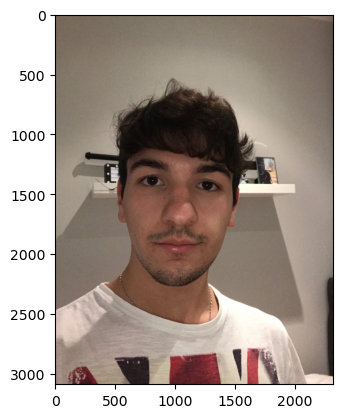

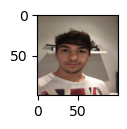

In [38]:
# Obervar la primera imagen
image = ImageOps.exif_transpose(Image.open(IMAGE_FILES[0]))
DPI = 96 # pixeles por pulgada
width, height = image.size

plt.imshow(image)
print('Dimensiones:', width, ',', height)

downscaled_img = image.resize((100, 100))
plt.figure(figsize=(100/ DPI, 100 / DPI))
plt.imshow(downscaled_img)

### Imágenes como tensores
Entonces generamos las imágenes escaladas a $100 \times 100$ pixeles y de paso las convertimos a tensores torch para poder usarlas en la red

In [39]:
# Cambiamos el tamanno de las imagenes y las transformamos en tenseres
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

TRANSFORMED_IMGS = []
for img_file_path in tqdm(IMAGE_FILES, desc="Transformando imagenes a tensores", leave=True):
    img = Image.open(img_file_path)
    img = ImageOps.exif_transpose(img).convert("RGB")
    TRANSFORMED_IMGS.append(transformation(img))

Transformando imagenes a tensores:   0%|          | 0/377 [00:00<?, ?it/s]

## Base de datos supervisada

Se puede notar que cada selfie está contenida en una dirección con el nombre de la persona a la que corresponde, por lo que basta usar la dirección de una carpeta anterior a la selfie, como identificador.

In [40]:
print("Dirección "+ IMAGE_FILES[0])
print("Identificador "+IMAGE_FILES[0].split('/')[-2])

Dirección /home/leonel/.cache/kagglehub/datasets/tapakah68/selfies-id-images-dataset/versions/5/Selfies ID Images dataset/18_sets_ Caucasians/0001ca9b9a--61ad04a074501f072eccf903_age_20_name_Alessandro/Selfie_4.jpg
Identificador 0001ca9b9a--61ad04a074501f072eccf903_age_20_name_Alessandro


Una vez identificadas las personas, creamos un dataset, que tendrá una estructura de diccionario. Donde las llaves son los identificadores de cada persona y los valores son listas con el número de selfie que corresponden a cada individuo.


In [41]:
def organized_dataset(image_files: list[str]) -> dict:
    dataset = {}
    for i, image_full_path in enumerate(image_files):
        person_id = image_full_path.split('/')[-2]
        if person_id not in dataset:
            dataset[person_id] = []
        dataset[person_id].append(i)
    return dataset
    
DATASET = organized_dataset(IMAGE_FILES)
n_dataset = len(DATASET)
print('Personas:', n_dataset)

Personas: 29


Extraemos a dos personas del dataset, con el fin de usarlas para una evaluación adicional.

In [42]:
keys_ite = iter(DATASET.keys())
key_0 = next(keys_ite)
key_1 = next(keys_ite)

external_people_files = {}
external_people_files[key_0] = DATASET[key_0]
external_people_files[key_1] = DATASET[key_1]

del DATASET[key_0]
del DATASET[key_1]


Para tener los datos supervisados, es necesario emparejar las imágenes y asignarles el valor 0 si son personas diferentes y el valor 1 si son la misma persona.

In [43]:
def supervised_dataset(dataset: dict) -> tuple[list, list]:
    same_people = []
    diff_people = []
    all_ids = set(dataset.keys())
    
    for person_id in dataset.keys():
        # computing matching_img, same person
        for img_j in dataset[person_id]:
            for img_k in dataset[person_id]:
                same_people.append((img_j, img_k, 1))


        # computing mismatching_img, different person
        all_ids.remove(person_id) # temporary remove to compare with others
        for img_i in dataset[person_id]:
            for other_person_id in all_ids:
                mismatched_img = list(map(lambda x: (img_i, x, 0), dataset[other_person_id]))
                diff_people.extend(mismatched_img)
        all_ids.add(person_id)

    return diff_people, same_people
    
CLASS0, CLASS1 = supervised_dataset(DATASET)
print(f"Personas diferentes: {len(CLASS0)} \n Mismas persona: {len(CLASS1)}")

Personas diferentes: 118638 
 Mismas persona: 4563


Con el fin de obtener una base de datos balanceada, es decir que la mitad de los datos pertenezcan a una clase y la otra mitad a la otra, tomamos datos al azar de la clase 0, tantos como elementos haya de la clase 1.

Después juntamos los datos y separamos en datos de entrenamiento y de evaluación y validación con un esquema 60-20-20

In [44]:
#Reducimos los casos 0 para que sea parejo con la clase1 

class1_size = int(len(CLASS1))

CLASS0_SAMPLES = random.sample(CLASS0, class1_size)

CLASSES = random.sample(CLASS1 + CLASS0_SAMPLES, class1_size * 2)

data_train_indexes, data_eval_indexes = train_test_split(CLASS1 + CLASS0_SAMPLES, train_size=0.6)
data_val_indexes, data_eval_indexes = train_test_split(data_eval_indexes, train_size=0.5)

print(data_train_indexes[:10])
print(data_eval_indexes[:10])
print(data_val_indexes[:10])

print('Tama~no dataset entrenamiento:', len(data_train_indexes))
print('Tama~no dataset evaluacion:', len(data_eval_indexes))
print('Tama~no dataset evaluacion:', len(data_val_indexes))

[(187, 112, 0), (230, 230, 1), (336, 296, 0), (82, 79, 1), (89, 88, 1), (35, 34, 1), (97, 237, 0), (31, 28, 1), (332, 75, 0), (139, 130, 1)]
[(376, 374, 1), (198, 195, 1), (158, 167, 1), (366, 79, 0), (44, 42, 1), (311, 302, 1), (307, 301, 1), (75, 157, 0), (365, 125, 0), (373, 373, 1)]
[(164, 165, 1), (63, 374, 0), (91, 209, 0), (302, 221, 0), (57, 58, 1), (122, 120, 1), (58, 373, 0), (194, 254, 0), (237, 239, 1), (239, 247, 0)]
Tama~no dataset entrenamiento: 5475
Tama~no dataset evaluacion: 1826
Tama~no dataset evaluacion: 1825


### Clase de dataset

Generamos una clase en la que se guardan tuplas con los índices de la variable IMAGE_FILES, ie donde están todas las direcciones a las imagenes. Y su respectivo índice a la variable TRANSFORMED_IMGS que guarda las imágenes en formato tensor de torch

In [45]:
class PreprocessedDataset(Dataset):
    def __init__(self, data: list[tuple], images):
        self.data = deepcopy(data) # no guardamos las imagenes, sino los tuplas con indices de posicion en IMAGE_FILES y TRANSFORMED_IMGS
        for i, (img1_i, img2_i, label) in enumerate(self.data):
            self.data[i] = img1_i, img2_i, torch.from_numpy(np.array([label], dtype=np.float32))
        self.images = images
        
    def __getitem__(self, index):
        img1_index, img2_index, label = self.data[index]
        img1 = self.images[img1_index] 
        img2 = self.images[img2_index] 
        return img1, img2, label
        
    def __len__(self):
        return len(self.data)


Generamos los dataset de entrenamiento y evaluación

In [46]:
dataset_train = PreprocessedDataset(data_train_indexes, TRANSFORMED_IMGS) #Para poder meterlo en dataloader
dataset_eval = PreprocessedDataset(data_eval_indexes, TRANSFORMED_IMGS) #Para poder meterlo en dataloader
dataset_val = PreprocessedDataset(data_val_indexes, TRANSFORMED_IMGS) 

## Mini Batches

Primero definimos dos funciones para poder observer las imágenes que vamos utilizando, que sea compatible con los mini batches

In [47]:
#Funciones para mostrar imagenes
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def distances_to_classes(distances):
    classes = []
    for distance in distances:
        if distance < 1.0:
            classes.append(1)
        else: 
            classes.append(0)
    return classes

La función DataLoader permite organizar los datos. Elegimos como tamaño del batch, 8 datos para poder visualizarlos correctamente

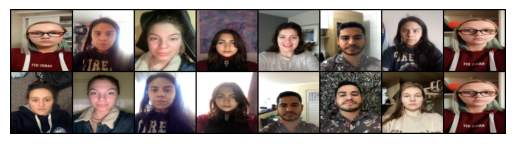

[0. 0. 0. 1. 0. 1. 0. 1.]
Las dimensiones de un batch son: torch.Size([8, 3, 100, 100]) 
 siendo tamaño del batch, canales RGB, ancho y largo de la imagen, respectivamente


In [48]:

# Creamos un dataloader para visualizar los datos
vis_dataloader = DataLoader(dataset_train,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# tomamos un batche
example_batch = next(iter(vis_dataloader))

#Concatenamos los pares de imagen para visualizar los datos
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated, nrow=8, padding=2, normalize=True, scale_each=True))
print(example_batch[2].numpy().reshape(-1))

print(f"Las dimensiones de un batch son: {example_batch[0].shape} \n siendo tamaño del batch, canales RGB, ancho y largo de la imagen, respectivamente")

# Red Neuronal

### Arquitectura
La red neuronal que se está usando tiene una arquitectura conocida como **red siamesa**. La red tiene tres capas convolucionales, cada una con activación ReLU y con pooling basado en el máximo. También cuenta con una capa aplanamiento, y después es introducida a una capa con activación ReLU y después una activación Lineal.

La diferencia con una red meramente convolucional, es que esta red recibe como entrada dos imágenes y saca un resultado para cada una. Después se calcula la diferencia entre los dos vectores de salida de la red y esa es la respuesta general. 

El objetivo aquí es entrenar la red de tal forma que si las imágenes son la misma persona, entonces el vector de salida de la red, sea parecido para ambas imágenes. Logrando esto, la diferencia entre los dos vectores de salida correspondiente a cada imágen, debe dar cercano a $0$ si son la misma persona y un valor más grande si no lo son. Idealmente mayor a $1$

In [91]:
# Creamos la red 
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Capas convolucionales para extraer las caracteristicas de las imagenes
        self.conv1 = nn.Conv2d(3, 8, kernel_size=7, stride=1, padding=3) 
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        #ir de 3 -> 8 -> 16 -> 32 es un patron comun que nos asegura que la red tenga la capacidad de aprender caracteristicas cada vez
        #mas complejas mientras que se va reduciondo la imagen
        # A la vez bajar el kernel permite optimizar un poco la red
        # Y el padding es para conservar las dimensiones espaciales despues de la convolucion
        
        # Max pool para reducir la dimension espacial
        self.pool = nn.MaxPool2d(2, 2) 


        #Las capas completamente conectadas toma las caracteristicas obtenidas en la parte cnn
 
        self.fc1 = nn.Linear(32 * 12 * 12, 1024) 
        self.bn_fc1 = nn.BatchNorm1d(1024) 
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 128) 


        #Obtenemos una representacion compacta de las caracteristicas de la imagen
        
    def forward_once(self, x):
        # Aplicamos la parte convolucional con relu
        #F.relu es puramente funcional (no objeto) aplica directamente la activacion
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        #Aplanamos el resultado para pasarla a la parte FeedForward
        x = x.view(x.size(0), -1) 

        #fc1 linear toma las caracteristicas obtenidas por la parte convolucional y las procesa para tener caracteristicas de alto nivel
        #ReLU para que la red aprenda patrones mas complejos
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)  # fc2 linear da el vector final en este caso de tamaño 128
        return x

    def forward(self, input1, input2):
        
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

### Función de error
La función de error que se usará es conocida como **Contrastive Loss function** que justamente sirve para optimizar diferencias entre dos entradas. Se define como sigue $$ \frac{1}{2} (1-Y) D_w^2 + \frac{1}{2} Y (max\{0, m - D_w\})^2 $$

Donde $Y$ representa el valor esperado {0,1}, es decir la etiqueta. $D_w$ es la distancia euclideana entre los dos vectores de salida de la red neuronal y $m$ es el margen que sirve como referencia. Es un hiper parámetro que se ajusta de acuerdo a la red, en nuestro caso se usó $m=2$

In [92]:
class ContrastiveLoss(torch.nn.Module):
    #El margen es importante porque funciona respecto a nuestro dataset
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculamos la distancia euclidiana entre los dos resultados y luego la perdida
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        loss_positive = label * torch.pow(euclidean_distance, 2)  # For similar pairs
        loss_negative = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)  #
        loss_contrastive = torch.mean(loss_positive + loss_negative)

        return loss_contrastive

# Entrenamiento

Ahora sí, generamos los mini batches para el entrenamiento, con tamaño 32

In [93]:
# Load the training dataset
train_dataloader = DataLoader(dataset_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)
val_dataloader = DataLoader(dataset_val,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

Si la máquina es compatible con cuda, es posible usar el dispositivo "gpu" en lugar de "cpu"

In [94]:
device = torch.device("cpu")

Instanciamos la red neuronal, la función de pérdida y el optimizador ADAM con una tasa de aprendizaje de 0.001

In [95]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay=1e-4 )

Entrenamos la red neuronal con los datos. Iterando sobre épocas y luego sobre los mini batches.

Para evitar el overfitting usamos la estrategia de Early Stopping en la que vamos usando datos de validación con un contador de paciencia de 10.

In [96]:
# Entrenamiento
counter = [] #Variable para poder graficar como cambia la perdida durante las epocas
loss_history = [] 
val_loss_history = []
iteration_number= 0


#Para early Stopping
best_model_weights = None
best_val_loss = float('inf')
min_d = 0.0001
patience = 10  
patience_counter = 0

for epoch in tqdm(range(10), desc="Entrenando", leave=True):
    print('\nEpoch', epoch, ' - loss history: ', end='')
    net.train()
    train_loss = 0
    dataiter = iter(val_dataloader)
    #img son tensoresn
    # itermos por batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        # Mandamos las imagenes al cpu
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Receteamos el gradiente 
        optimizer.zero_grad()

        # Pasamos las imagenes a la red 
        output1, output2 = net(img0, img1)

        # Calculamos la perdida 
        loss_contrastive = criterion(output1, output2, label)

        # Parte de aprendizaje 
        loss_contrastive.backward()

        # Optimizamos
        optimizer.step()

        # Para ver el proceso cada 10 batches (batch size 32)
        if i % 10 == 0 :
            print(f"Current loss: {loss_contrastive.item()}")
            iteration_number += 50

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

            net.eval()
            val_loss = 0
            with torch.no_grad():  # Disable gradients during validation
                img0, img1, label = next(dataiter)
                img0, img1, label = img0.to(device), img1.to(device), label.to(device)

                    # Forward pass
                output1, output2 = net(img0, img1)

                    # Calculate loss
                loss = criterion(output1, output2, label)
                val_loss = loss.item()
            val_loss_history.append(val_loss)
            print(f" Validation loss: {val_loss}")

            if val_loss < best_val_loss - min_d:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_weights = net.state_dict() #Guardamos los mejores pesos
            else:
                patience_counter += 1
            net.train()
            if patience_counter >= patience:
                print("Early stopping XXXXXX.")
                break 
    if patience_counter >= patience:
            break
net.load_state_dict(best_model_weights)
    

Entrenando:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 0  - loss history: 

Current loss: 13.07792854309082
 Validation loss: 2.376067638397217
Current loss: 3.2830588817596436
 Validation loss: 1.1424928903579712
Current loss: 1.1871309280395508
 Validation loss: 1.7520034313201904
Current loss: 0.7858896255493164
 Validation loss: 1.1693134307861328
Current loss: 0.6417345404624939
 Validation loss: 0.7007648944854736
Current loss: 0.6278347969055176
 Validation loss: 0.877193808555603
Current loss: 0.6277129650115967
 Validation loss: 0.42096829414367676
Current loss: 0.6402125954627991
 Validation loss: 0.7528080344200134
Current loss: 0.712473452091217
 Validation loss: 0.602023184299469
Current loss: 0.7900534868240356
 Validation loss: 0.5520676970481873
Current loss: 0.5883315205574036
 Validation loss: 0.5403982400894165
Current loss: 0.39665651321411133
 Validation loss: 0.528885006904602
Current loss: 0.5250045657157898
 Validation loss: 0.42627692222595215
Current loss: 0.5481668710708618
 Validation loss: 0.4803200364112854
Current loss: 0.6135929

<All keys matched successfully>

Se puede observar como la red neuronal fue mejorando, alcanzando valores bajos para la función de error.
Graficamos dichos valores para observar cómo fue el comportamiento del entrenamiento de la red.

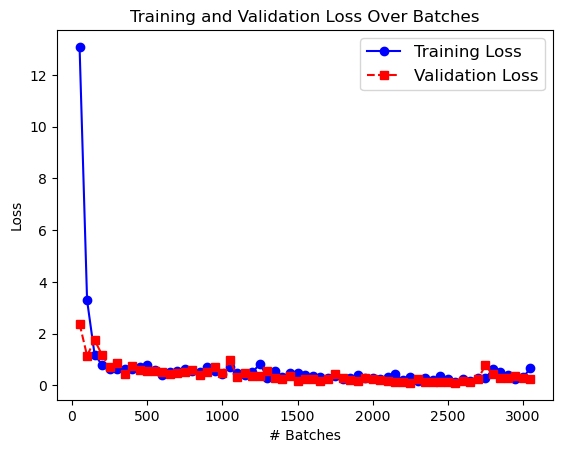

In [97]:
plt.plot(counter, loss_history, label='Training Loss', color='blue', marker='o', linestyle='-')
plt.plot(counter, val_loss_history, label='Validation Loss', color='red', marker='s', linestyle='--')
plt.xlabel('# Batches')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Batches')
plt.legend(fontsize=12)
plt.show()

# Evaluación

Como debemos de pasar de una distancia entre los vectores salientes de la red neuronal, a una clasificación, definimos la función que separa los datos, dependiendo de sus distancias. Tomando como criterio, si es mayor a 1, entonces son diferentes y si la distancia es menor, entonces son la misma persona

Realizamos una evaluación visible con algunos datos para ver si efectivamente está realizando correctamente la clasificación.

1826
tensor([[1.]])


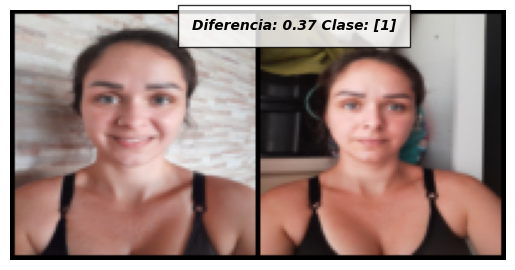

tensor([[1.]])


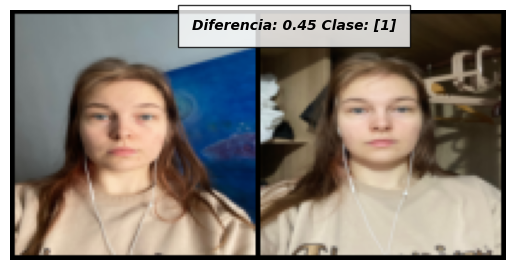

tensor([[1.]])


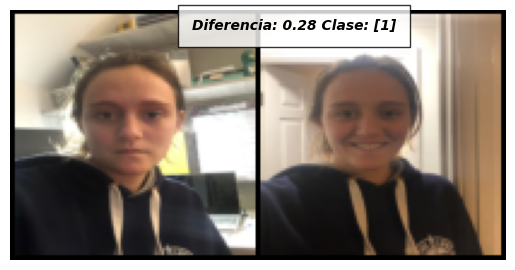

tensor([[0.]])


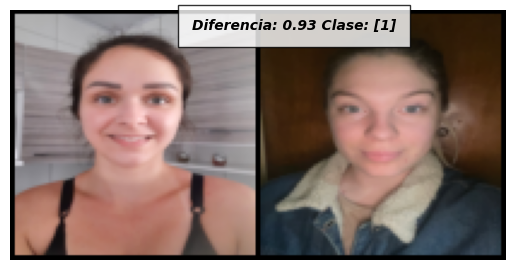

tensor([[1.]])


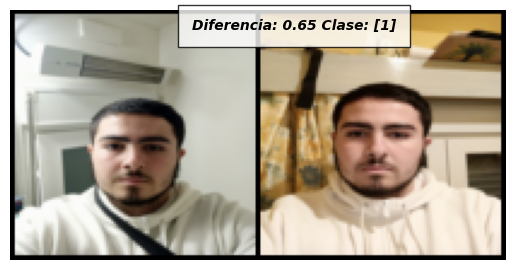

tensor([[1.]])


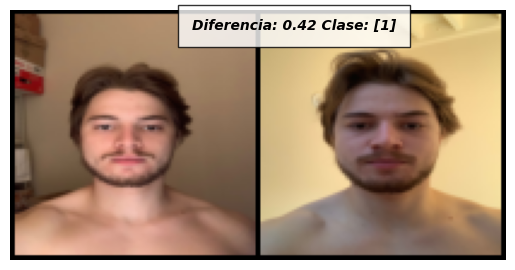

tensor([[1.]])


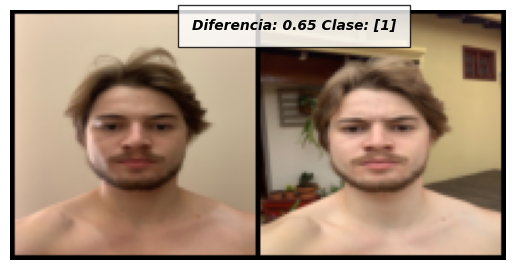

tensor([[0.]])


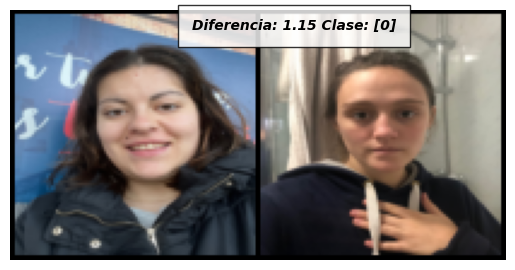

tensor([[0.]])


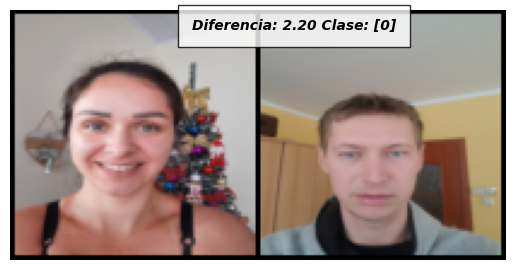

tensor([[1.]])


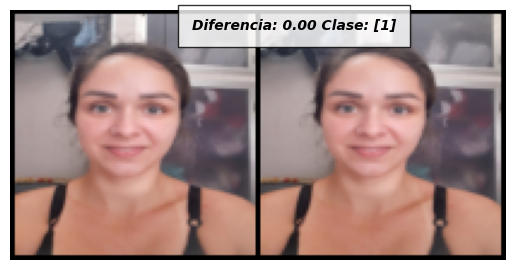

In [100]:
eval_dataloader = DataLoader(dataset_eval, num_workers=2, batch_size=1, shuffle=False) #shuffle false para que no se pierda el orden de
# las etiquetas, al delimitar el tamanno de las CLASSES se tomaron de forma aleatoria entonces se puede decir que estan revueltas aun asi
net.eval()
dataiter = iter(eval_dataloader)
print(len(eval_dataloader))
for i in range(10):
    x0, x1, label2 = next(dataiter)
    print(label2)
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Diferencia: {euclidean_distance.item():.2f} Clase: {distances_to_classes(euclidean_distance)}')

Ahora clasificamos todos los datos de evaluación y los guardamos en una variable

In [101]:
net.eval()
eval_dataloader = DataLoader(dataset_eval, num_workers=8, batch_size=8, shuffle=False) #shuffle false para que no se pierda el orden de

distances = []
labels_eval = []
for i, (img0, img1, label) in enumerate(eval_dataloader, 0):
    output1, output2 = net(img0.to(device), img1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    distances += euclidean_distance
    labels_eval += label

y_pred = distances_to_classes(distances)

Después realizamos un reporte de las clasificaciones con medidas como Exaxtitud, Precisión, Exahustividad y F1

In [102]:
print(classification_report(y_pred, labels_eval, target_names=['Class 0', 'Class 1'], zero_division=0))

              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98       886
     Class 1       1.00      0.97      0.98       940

    accuracy                           0.98      1826
   macro avg       0.98      0.98      0.98      1826
weighted avg       0.98      0.98      0.98      1826



## Extrapolación de la Red
Adicionalmente, vemos cómo realiza la clasificación con personas que no fueron usadas para el entrenamiento.

676
tensor([[1.]])


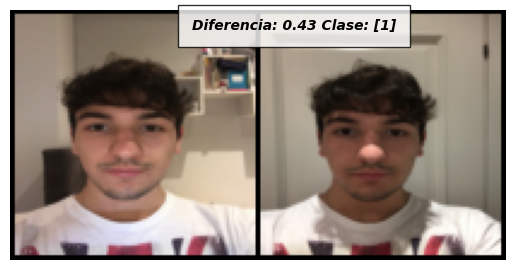

tensor([[1.]])


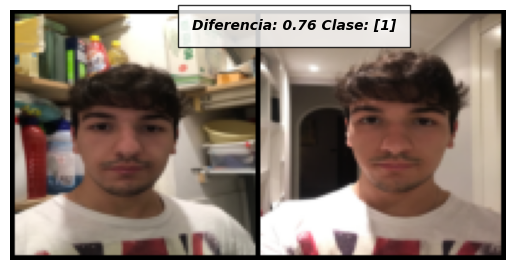

tensor([[0.]])


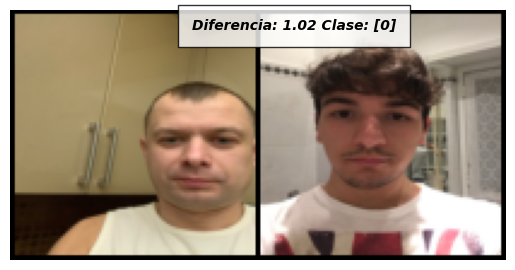

tensor([[1.]])


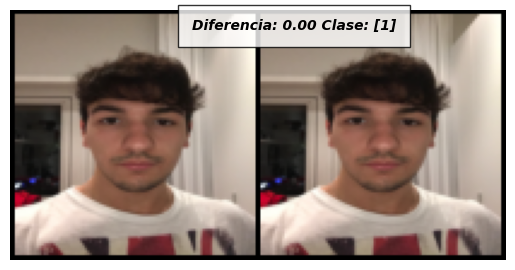

tensor([[0.]])


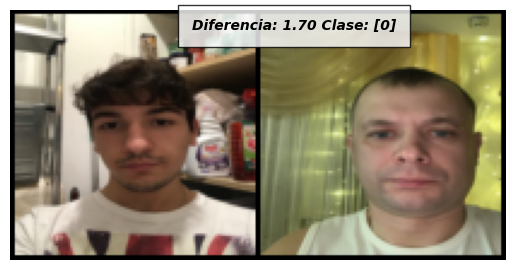

tensor([[0.]])


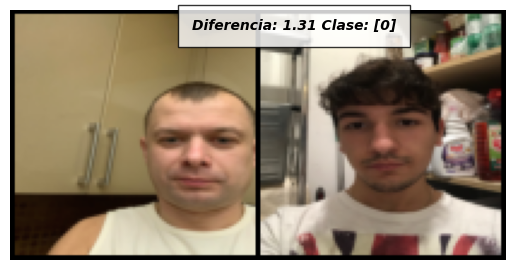

tensor([[0.]])


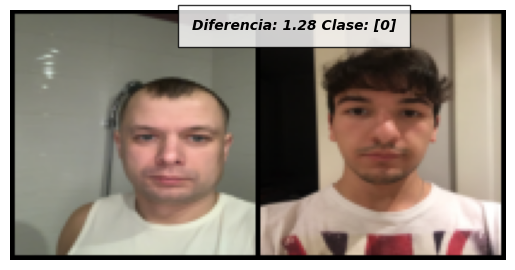

tensor([[1.]])


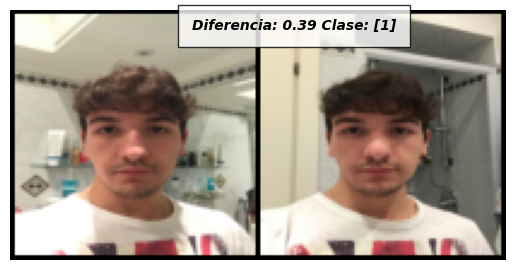

tensor([[1.]])


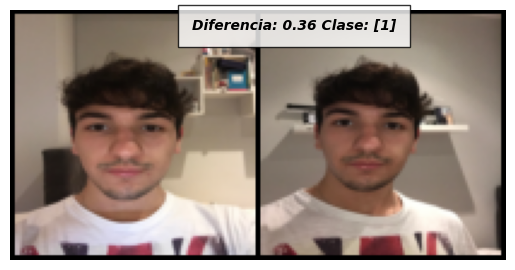

tensor([[1.]])


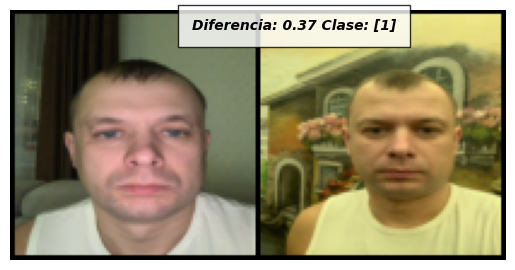

In [103]:
ext_people_indexes_0 , ext_people_indexes_1 = supervised_dataset(external_people_files)
ext_people_indexes = ext_people_indexes_0 + ext_people_indexes_1

external_people_dataset = PreprocessedDataset(ext_people_indexes, TRANSFORMED_IMGS)
external_people_dataloader = DataLoader(external_people_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)

dataiter = iter(external_people_dataloader)
print(len(external_people_dataloader))
for i in range(10):
    x0, x1, label2 = next(dataiter)
    print(label2)
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Diferencia: {euclidean_distance.item():.2f} Clase: {distances_to_classes(euclidean_distance)}')

Evaluamos la Red con las dos personas que no se usaron para entrenar a la red.

In [104]:
distances = []
labels_eval = []
for i, (img0, img1, label) in enumerate(external_people_dataloader, 0):
    output1, output2 = net(img0.to(device), img1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    distances.append(euclidean_distance.item())
    labels_eval.append(int(label.item()))

y_pred = distances_to_classes(distances)

print(classification_report(y_pred, labels_eval, target_names=['Class 0', 'Class 1'], zero_division=0))

              precision    recall  f1-score   support

     Class 0       0.72      0.88      0.79       274
     Class 1       0.91      0.76      0.83       402

    accuracy                           0.81       676
   macro avg       0.81      0.82      0.81       676
weighted avg       0.83      0.81      0.81       676



### Conclusiones
Como se puede apreciar, la red no realiza tan buen trabajo con estas personas como con las que se usaron para el entrenamiento. Sin embargo, en parte se debe al parámetro utilizado para separar las clasificaciones, es decir que el valor de distancia $1$ sea la separación, en algunos casos falla. Sin embargo, suele ser menor la distancia cuando son las mismas personas en general. Sería útil realizar un mayor estudio sobre qué parámetros se pueden modificar adicionalmente, para poder tener mejore resultados a la hora de extrapolar el modelo.

# Referencias

Una parte del codigo y guia del proyecto se baso por el trabajo de dataHacker en su video y repositorio.
Gracias por compartir este recurso, el cual fue de gran ayuda para el desarrollo de este modelo.

repositorio: https://github.com/maticvl/dataHacker/blob/master/pyTorch/014_siameseNetwork.ipynb
video: https://www.youtube.com/watch?v=9hLcBgnY7cs&t=296s

